# DDX6 eCLIP and A-to-I RNA editing regulation analysis workflow

## 1. DDX6 RNA-Seq editing analysis

+ RNA-sequencing were performed in DDX6, DDX3X, DDX10, DHX30, DDX21, and DDX17 knock-down cells.
+ A-to-I RNA editing sites were identified using a published pipeline as described by Hong et al. (2018) in https://doi.org/10.1093/nar/gky396.
+ Briefly, paired end fastq files were aligned using BWA and junction-spanning reads were retained for variant calling using Perl.
+ Editing sites were annotated using ANNOVAR and common SNP were removed.
+ For editing change ($\Delta VAF$) calculation, candidate editing sites were filtered by coverage and basal editing frequency as described in the manuscript.
+ Editing change were calculated by taking the difference in VAF between sh and Scr samples for each Helicase knockdown experiment.

${\Delta}VAF_{knockdown} = \frac{\sum{VAF_{sh} - VAF_{Scr}}}{n}$

## 2. DDX6 eCLIP

+ eCLIP-sequencing were performed for DDX6 CLIP, IgG, and input RNA samples.
+ DDX6 eCLIP-Seq fastq files were processed and analysed using a published eCLIP pipeline CWL workflow from [GitHub](https://github.com/YeoLab/eCLIP.git) as described by Van Nostrand et al. (2016) in https://doi.org/10.1038/nmeth.3810.
+ Briefly, IP and input paired end fastq files were first demultiplexed and aligned to the hg19 reference human genome, followed by peak enrichment analysis using the CLIPPER software. IP peak fold changes for IP samples were normalised against the corresponding input sample.
+ Peaks were filtered using a cutoff of log2(FC) > 2 and log10(P-value) > 2.
+ Finally, filtered peaks were annotated using homer annotatePeaks.pl.

In [1]:
#!/bin/bash
find /home/csiv149/data/Larry/larry_peakDensity -name "DDX6_eCLIP_peaks.*.bed" | sort


/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks.IgG.bed
/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks.XL1.bed
/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks.XL2.bed


In [2]:
#!/bin/bash
for peakfile in /home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks.*.bed
do
echo $peakfile > /dev/stderr
gawk -F"\t" '$6>2 && $5>2' $peakfile ${peakfile%%.*}_filter_with_logFC.${peakfile#*.}
done


/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks.IgG.bed
/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks.XL1.bed
/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks.XL2.bed


In [3]:
#!/bin/bash
for filtpeakfile in /home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.*.bed
do
echo $filtpeakfile > /dev/stderr
homer/bin/annotatePeaks.pl $filtpeakfile hg19 > ${filtpeakfile%.bed}.anno.txt
done


/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.IgG.bed
/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.XL1.bed
/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.XL2.bed


## 3. Overlap between DDX6-regulated editing sites and DDX6-eCLIP peaks

+ To obtain DDX6-bound editing sites, DDX6-regulated editing site genomic coordinates were extended by 4000 nt both upstream and downstream, and intersected with signifiant DDX6-binding genomic regions.
+ DDX6-regulated and -bound editing sites from both DDX6_XL1 and DDX6_XL2 were merged to give the final set of DDX6 editing sites.
+ DDX6 eCLIP peak ratio and density distance plot were generated using custom in-house perl scripts provided in `scripts/`.

In [4]:
#!/bin/bash
wc -l differential_editing_sites.shDDX6_reg.bed


1095 differential_editing_sites.shDDX6_reg.bed


In [5]:
#!/bin/bash
(
cd /home/vincentt/data/rnaseq/larry
ln -s 962_differential_editing_sites_Updated_RNA_seq_editing_shDDX6_version_1.ddx6_up.bed  differential_editing_sites.shDDX6_reg.bed
wc -l differential_editing_sites.shDDX6_reg.bed
)


In [6]:
#!/bin/bash
for filtpeakfile in /home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.*.bed
do
echo $filtpeakfile > /dev/stderr
infile=${filtpeakfile##*/}

bedtools slop -i differential_editing_sites.shDDX6_reg.bed -g GRCh37.primary_assembly.genome.fa.fai -b 4000 \
| bedtools intersect -s -wa -a - -b $filtpeakfile \
| bedtools slop -i - -g GRCh37.primary_assembly.genome.fa.fai -b -4000 \
> differential_editing_sites_shDDX6_reg.${infile%.bed}.bed
done


/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.XL1.bed
/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.XL2.bed


In [7]:
#!/bin/bash
sort -k1,1 -k2,2n differential_editing_sites_shDDX6_reg.*.bed \
| bedtools merge -s -d -1 -c 4,5,6 -o first,max,distinct -i - \
> differential_editing_sites.ddx6reg_ddx6bound.bed


In [8]:
#!/bin/bash
mkdir -p sites_overlapped_eCLIP_peaks

for filtpeakfile in /home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.*.bed
do
echo $filtpeakfile > /dev/stderr
infile=${filtpeakfile##*/}

perl scripts/run_overlapping_and_find_relative_positions.considering_the_ranges_of_whole_peaks.pl \
differential_editing_sites.ddx6reg_ddx6bound.bed \
$filtpeakfile \
2000 \
sites_overlapped_eCLIP_peaks/ddx6reg_ddx6bound.overlapped_with.${infile.bed}.output.txt

awk '
{if ($(NF-1) < 0 && $NF <= 0) print "chr1\t"sqrt(($NF)^2)"\t"sqrt(($(NF-1)^2))}
' sites_overlapped_eCLIP_peaks/ddx6reg_ddx6bound.overlapped_with.${infile.bed}.output.txt \
| sort -k1,1 -k2,2n \
| bedtools genomecov -i - -g reference_file_maxLength_10000.txt -d \
| awk '{print $1"\t-"$2"\t"$3}' \
| sort -k1,1 -k2,2n \
> sites_overlapped_eCLIP_peaks/ddx6reg_ddx6bound.overlapped_with.${infile.bed}.output.txt.output  

done


/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.XL1.bed
/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.XL2.bed


## 4. Prediction of opposite nucleotide

+ Local structure and opposite nucleotide prediction was performed for each DDX6-regulated and -bound editing site using a published RNAfold pipeline as described by Brümmer et al. (2017) in https://doi.org/10.1038/s41467-017-01459-7.
+ Briefly, DDX6-regulated and -bound editing site genomic coordinates were first extended by 500 nt both upstream and downstream, and the corresponding stranded RNA sequence were used for local RNA structure using RNAfold. Finally, local structure types and opposite nucleotides were determined using the dot bracket notation MFE structure predicted by RNAfold.
+ The predicted opposite nucleotide pair of DDX6-regulated editing sites were classified as A-U (for opposite U base), A:C (for opposite C base), or non-ACAU (for all other bases) 

In [9]:
#!/bin/bash
awk -F"\t" -vOFS="\t" '{
    gsub("\\|","_",$4)
    #strand=($6=="+"?"for":"rev")
    system("mkdir -p opposite_nuc/"$4)
    print $1,$2,$3,$4,$5,$6 > "opposite_nuc/"$4/"$4".bed"
}' differential_editing_sites.ddx6reg_ddx6bound.bed


In [10]:
#!/bin/bash
for bedfile in `ls opposite_nuc/*/*.bed`
do
echo $bedfile

python /home/vincentt/git/SCRIPT_TO_IDENTIFY_THE_NUCLEOTIDE_OPPOSITE_TO_AN_EDITING_SITE_BASED_ON_RNAFOLD.txt \
-i $bedfile \
-g GRCh38.primary_assembly.genome.fa.fai \
-f GRCh38.primary_assembly.genome.fa \
-r RNAfold \
-l 500 \
-n A \
-o ${bedfile%.bed}.RNAfold_A.out

python /home/vincentt/git/SCRIPT_TO_IDENTIFY_THE_NUCLEOTIDE_OPPOSITE_TO_AN_EDITING_SITE_BASED_ON_RNAFOLD.txt \
-i $bedfile \
-g GRCh38.primary_assembly.genome.fa.fai \
-f GRCh38.primary_assembly.genome.fa \
-r RNAfold \
-l 500 \
-n G \
-o ${bedfile%.bed}.RNAfold_G.out
done


opposite_nuc/chr10_102764109_G/chr10_102764109_G.bed
opposite_nuc/chr10_102764887_G/chr10_102764887_G.bed
opposite_nuc/chr10_102764890_G/chr10_102764890_G.bed
opposite_nuc/chr10_102764895_G/chr10_102764895_G.bed
opposite_nuc/chr10_114209254_G/chr10_114209254_G.bed
opposite_nuc/chr10_114209912_G/chr10_114209912_G.bed
opposite_nuc/chr10_75009585_C/chr10_75009585_C.bed
opposite_nuc/chr10_75009720_C/chr10_75009720_C.bed
opposite_nuc/chr10_75009844_C/chr10_75009844_C.bed
opposite_nuc/chr11_111599275_G/chr11_111599275_G.bed
opposite_nuc/chr11_12983765_C/chr11_12983765_C.bed
opposite_nuc/chr11_17398770_G/chr11_17398770_G.bed
opposite_nuc/chr11_33096294_G/chr11_33096294_G.bed
opposite_nuc/chr11_33096395_G/chr11_33096395_G.bed
opposite_nuc/chr11_62506362_G/chr11_62506362_G.bed
opposite_nuc/chr11_62506416_G/chr11_62506416_G.bed
opposite_nuc/chr11_62506638_G/chr11_62506638_G.bed
opposite_nuc/chr11_62506990_G/chr11_62506990_G.bed
opposite_nuc/chr11_62507240_G/chr11_62507240_G.bed
opposite_nuc/chr1

opposite_nuc/chr16_22296938_G/chr16_22296938_G.bed
opposite_nuc/chr16_70407018_G/chr16_70407018_G.bed
opposite_nuc/chr16_713273_G/chr16_713273_G.bed
opposite_nuc/chr16_713318_G/chr16_713318_G.bed
opposite_nuc/chr16_713345_G/chr16_713345_G.bed
opposite_nuc/chr16_713363_G/chr16_713363_G.bed
opposite_nuc/chr16_81063319_G/chr16_81063319_G.bed
opposite_nuc/chr16_81064233_G/chr16_81064233_G.bed
opposite_nuc/chr16_81064439_G/chr16_81064439_G.bed
opposite_nuc/chr16_81064440_G/chr16_81064440_G.bed
opposite_nuc/chr16_81064534_G/chr16_81064534_G.bed
opposite_nuc/chr16_81064611_G/chr16_81064611_G.bed
opposite_nuc/chr16_81064629_G/chr16_81064629_G.bed
opposite_nuc/chr16_88785404_C/chr16_88785404_C.bed
opposite_nuc/chr16_9204744_G/chr16_9204744_G.bed
opposite_nuc/chr17_17089912_G/chr17_17089912_G.bed
opposite_nuc/chr17_2321606_C/chr17_2321606_C.bed
opposite_nuc/chr17_2321612_C/chr17_2321612_C.bed
opposite_nuc/chr17_37005835_C/chr17_37005835_C.bed
opposite_nuc/chr17_42877148_C/chr17_42877148_C.bed
op

opposite_nuc/chr1_36067833_C/chr1_36067833_C.bed
opposite_nuc/chr1_36068166_C/chr1_36068166_C.bed
opposite_nuc/chr1_36068184_C/chr1_36068184_C.bed
opposite_nuc/chr1_36068210_C/chr1_36068210_C.bed
opposite_nuc/chr1_36068295_C/chr1_36068295_C.bed
opposite_nuc/chr1_36068325_C/chr1_36068325_C.bed
opposite_nuc/chr1_36068370_C/chr1_36068370_C.bed
opposite_nuc/chr1_3730400_C/chr1_3730400_C.bed
opposite_nuc/chr1_45975345_G/chr1_45975345_G.bed
opposite_nuc/chr1_45975346_G/chr1_45975346_G.bed
opposite_nuc/chr1_45975498_G/chr1_45975498_G.bed
opposite_nuc/chr1_45975602_G/chr1_45975602_G.bed
opposite_nuc/chr1_53289547_G/chr1_53289547_G.bed
opposite_nuc/chr1_53291434_G/chr1_53291434_G.bed
opposite_nuc/chr1_53291435_G/chr1_53291435_G.bed
opposite_nuc/chr1_6280037_G/chr1_6280037_G.bed
opposite_nuc/chr1_6282401_C/chr1_6282401_C.bed
opposite_nuc/chr1_6283244_C/chr1_6283244_C.bed
opposite_nuc/chr1_6283260_C/chr1_6283260_C.bed
opposite_nuc/chr1_6283273_C/chr1_6283273_C.bed
opposite_nuc/chr1_6283305_C/chr1

opposite_nuc/chr5_125961447_G/chr5_125961447_G.bed
opposite_nuc/chr5_125961532_G/chr5_125961532_G.bed
opposite_nuc/chr5_125961554_G/chr5_125961554_G.bed
opposite_nuc/chr5_125961623_G/chr5_125961623_G.bed
opposite_nuc/chr5_125961648_G/chr5_125961648_G.bed
opposite_nuc/chr5_125961649_G/chr5_125961649_G.bed
opposite_nuc/chr5_125962030_G/chr5_125962030_G.bed
opposite_nuc/chr5_125962142_G/chr5_125962142_G.bed
opposite_nuc/chr5_174956178_G/chr5_174956178_G.bed
opposite_nuc/chr5_174956187_G/chr5_174956187_G.bed
opposite_nuc/chr5_313839_G/chr5_313839_G.bed
opposite_nuc/chr5_34906198_C/chr5_34906198_C.bed
opposite_nuc/chr5_34906242_C/chr5_34906242_C.bed
opposite_nuc/chr5_34906274_C/chr5_34906274_C.bed
opposite_nuc/chr5_34906487_C/chr5_34906487_C.bed
opposite_nuc/chr5_34906658_C/chr5_34906658_C.bed
opposite_nuc/chr5_34906661_C/chr5_34906661_C.bed
opposite_nuc/chr5_34906662_C/chr5_34906662_C.bed
opposite_nuc/chr5_34906700_C/chr5_34906700_C.bed
opposite_nuc/chr5_34953000_G/chr5_34953000_G.bed
oppo

In [11]:
#!/bin/bash
tail --quiet -n1 opposite_nuc/*/*.RNAfold_A.out > opposite_nuc.RNAfold_A.out


In [12]:
# append structure type and opposite nucleotide prediction list of editing sites
#!/bin/bash
awk -F"\t" -vOFS="\t" '
FNR==NR{
    STRUCTURETYPE[$1]=$(NF-1)
    OPPNUC[$1]=$NF
    next
}
{
    ESiteName=$4
    gsub("\\|","_",ESiteName)
    print $0,STRUCTURETYPE[ESiteName],OPPNUC[ESiteName]
}' \
opposite_nuc.RNAfold_A.out \
differential_editing_sites.ddx6reg_ddx6bound.bed \
> differential_editing_sites.ddx6reg_ddx6bound.tsv


In [13]:
#!/bin/bash
awk -F"\t" '$NF=="U"' differential_editing_sites.ddx6reg_ddx6bound.tsv | cut -f1-6 > differential_editing_sites.ddx6reg_ddx6bound.predicted_AU.bed
awk -F"\t" '$NF=="C"' differential_editing_sites.ddx6reg_ddx6bound.tsv | cut -f1-6 > differential_editing_sites.ddx6reg_ddx6bound.predicted_AU.bed
awk -F"\t" '$NF!~/[CU]/' differential_editing_sites.ddx6reg_ddx6bound.tsv | cut -f1-6 > differential_editing_sites.ddx6reg_ddx6bound.predicted_AU.bed


In [14]:
#!/bin/bash
wc -l differential_editing_sites.ddx6reg_ddx6bound.predicted_*.bed


  119 differential_editing_sites.ddx6reg_ddx6bound.predicted_AC.bed
  322 differential_editing_sites.ddx6reg_ddx6bound.predicted_AU.bed
  184 differential_editing_sites.ddx6reg_ddx6bound.predicted_nonACAU.bed
  625 total


In [15]:
#!/bin/bash
mkdir -p sites_overlapped_eCLIP_peaks_oppnuc

# A:C sites
for filtpeakfile in /home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.*.bed
do
echo $filtpeakfile > /dev/stderr
infile=${filtpeakfile##*/}

perl scripts/run_overlapping_and_find_relative_positions.considering_the_ranges_of_whole_peaks.pl \
differential_editing_sites.ddx6reg_ddx6bound.predicted_AC.bed \
$filtpeakfile \
2000 \
sites_overlapped_eCLIP_peaks_oppnuc/ddx6reg_ddx6bound_predicted_AC.overlapped_with.${infile.bed}.output.txt

awk '
{if ($(NF-1) < 0 && $NF <= 0) print "chr1\t"sqrt(($NF)^2)"\t"sqrt(($(NF-1)^2))}
' sites_overlapped_eCLIP_peaks_oppnuc/ddx6reg_ddx6bound_predicted_AC.overlapped_with.${infile.bed}.output.txt \
| sort -k1,1 -k2,2n \
| bedtools genomecov -i - -g reference_file_maxLength_10000.txt -d \
| awk '{print $1"\t-"$2"\t"$3}' \
| sort -k1,1 -k2,2n \
> sites_overlapped_eCLIP_peaks_oppnuc/ddx6reg_ddx6bound_predicted_AC.overlapped_with.${infile.bed}.output.txt.output  
done

# A-U sites
for filtpeakfile in /home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.*.bed
do
echo $filtpeakfile > /dev/stderr
infile=${filtpeakfile##*/}

perl scripts/run_overlapping_and_find_relative_positions.considering_the_ranges_of_whole_peaks.pl \
differential_editing_sites.ddx6reg_ddx6bound.predicted_AU.bed \
$filtpeakfile \
2000 \
sites_overlapped_eCLIP_peaks_oppnuc/ddx6reg_ddx6bound_predicted_AU.overlapped_with.${infile.bed}.output.txt

awk '
{if ($(NF-1) < 0 && $NF <= 0) print "chr1\t"sqrt(($NF)^2)"\t"sqrt(($(NF-1)^2))}
' sites_overlapped_eCLIP_peaks_oppnuc/ddx6reg_ddx6bound_predicted_AU.overlapped_with.${infile.bed}.output.txt \
| sort -k1,1 -k2,2n \
| bedtools genomecov -i - -g reference_file_maxLength_10000.txt -d \
| awk '{print $1"\t-"$2"\t"$3}' \
| sort -k1,1 -k2,2n \
> sites_overlapped_eCLIP_peaks_oppnuc/ddx6reg_ddx6bound_predicted_AU.overlapped_with.${infile.bed}.output.txt.output  
done

# non-A:C/A-U sites
for filtpeakfile in /home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.*.bed
do
echo $filtpeakfile > /dev/stderr
infile=${filtpeakfile##*/}

perl scripts/run_overlapping_and_find_relative_positions.considering_the_ranges_of_whole_peaks.pl \
differential_editing_sites.ddx6reg_ddx6bound.predicted_nonACAU.bed \
$filtpeakfile \
2000 \
sites_overlapped_eCLIP_peaks_oppnuc/ddx6reg_ddx6bound_predicted_nonACAU.overlapped_with.${infile.bed}.output.txt

awk '
{if ($(NF-1) < 0 && $NF <= 0) print "chr1\t"sqrt(($NF)^2)"\t"sqrt(($(NF-1)^2))}
' sites_overlapped_eCLIP_peaks_oppnuc/ddx6reg_ddx6bound_predicted_nonACAU.overlapped_with.${infile.bed}.output.txt \
| sort -k1,1 -k2,2n \
| bedtools genomecov -i - -g reference_file_maxLength_10000.txt -d \
| awk '{print $1"\t-"$2"\t"$3}' \
| sort -k1,1 -k2,2n \
> sites_overlapped_eCLIP_peaks_oppnuc/ddx6reg_ddx6bound_predicted_nonACAU.overlapped_with.${infile.bed}.output.txt.output  
done


/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.XL1.bed
/home/csiv149/data/Larry/larry_peakDensity/DDX6_eCLIP_peaks_filter_with_logFC.XL2.bed


## 5. Visualisation of Peak ratio distance plot for predicted DDX6-regulated A:C/A-U editing sites
+ Normalised peak ratios were calculated by normalising the summed peak counts at base positions ±1000 nt flanking DDX6-regulated editing sites to the set size and scaled against the maximum peak count.

#### IRkernel

In [1]:
# run in R 4.3.1
library(tidyverse)
library(reshape2)
library(ggplot2)


── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.2     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [2]:
# run in R 4.3.1
output_ddx6_acau.list <- list.files(
    path = 'sites_overlapped_eCLIP_peaks_oppnuc',
    pattern = 'ddx6reg_ddx6bound_predicted_(AC|AU|nonACAU).overlapped_with.DDX6_eCLIP_peaks_filter_with_logFC.XL[12].output.txt.output$',
    full.names = TRUE
) %>% 
lapply(function(inpath) {
    read.table(file = inpath,header = FALSE,sep = '\t') %>%
    mutate(Sample = gsub('.*/|.output..*','',inpath))
})


In [3]:
# run in R 4.3.1
output_ddx6_acau.df <- output_ddx6_acau.list %>% 
bind_rows() %>% 
group_by(Sample) %>% 
reframe(
    V1=V1,V2=V2,V3=V3,
    editing_siteset=gsub('.overlapped_with..*','',Sample),
    eclip_peakset=gsub('.*.overlapped_with.DDX6_eCLIP_peaks_filter_with_logFC.','',eCLIP_peak),
) %>% 
mutate(
    peaksize=c(
        ddx6reg_ddx6bound_predicted_AC = 119,
        ddx6reg_ddx6bound_predicted_AU = 322,
        ddx6reg_ddx6bound_predicted_nonACAU = 184
    )[editing_siteset %>% as.character]
) %>% 
mutate(
    Peak.ratio = V3 / peaksize
)


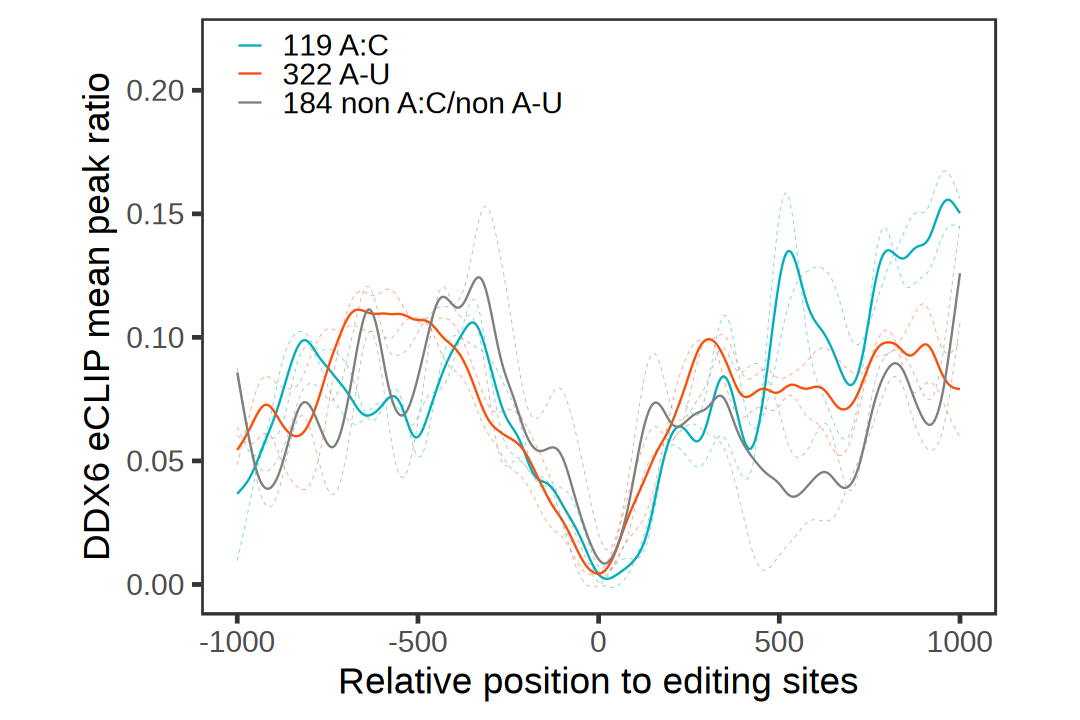

In [4]:
# run in R 4.3.1
options(repr.plot.width=9,repr.plot.height=6)

g <- output_ddx6_acau.df %>% 
subset((V2 %>% abs)<=1000) %>% 
mutate(editing_siteset=editing_siteset %>% factor(levels=paste0('ddx6reg_ddx6bound_predicted_',c('AC','AU','nonACAU')),labels=c('A:C','A-U','non A:C/non A-U'))) %>% 

(function(.) ggplot(.,
    mapping=aes(
        x=V2,
        y=Peak.ratio,
        col=editing_siteset
    )
) +
geom_point(size=.1,col='black',alpha=0) +
ggformula::geom_spline(data = group_by(.,V2,editing_siteset) %>% reframe(Peak.ratio = Peak.ratio %>% mean),linewidth=.5,spar=.6) +
ggformula::geom_spline(data = filter(.,eclip_peakset=='XL1'),linewidth=.2,spar=.6,alpha = .5,linetype = 'dashed') +
ggformula::geom_spline(data = filter(.,eclip_peakset=='XL2'),linewidth=.2,spar=.6,alpha = .5,linetype = 'dashed') +
scale_color_manual(
    name='',
    values = c('A:C'='#00AFBB','A-U'='#FC4E07','non A:C/non A-U'='gray50'),
    labels=c('119 A:C','322 A-U','184 non A:C/non A-U')
) +
coord_cartesian(xlim=c(-1000,1000)) +
labs(x='Relative position to editing sites',y='DDX6 eCLIP mean peak ratio') +
theme_bw(base_size = 22) +
theme(panel.grid = element_blank(),
    aspect.ratio = 3/4,plot.title = element_text(hjust=.5),strip.text = element_text(size=16),
    legend.background = element_blank(),
    legend.position = 'inside',
    legend.position.inside = c(.25,.95)
))

g


In [5]:
# run in R 4.3.1
# Scaled peak ratio was exported and plotted in Prism GraphPad
output_ddx6_acau.df %>% 
subset((V2 %>% abs)<=1000) %>% 
mutate(editing_siteset=editing_siteset %>% factor(levels=paste0('ddx6reg_ddx6bound_predicted_',c('AC','AU','nonACAU')),labels=c('A:C','A-U','non A:C/non A-U'))) %>% 
group_by(V2,editing_siteset) %>% reframe(Peak.ratio.mean = Peak.ratio %>% mean) %>% ungroup %>% 
mutate(Peak.ratio.norm = Peak.ratio.mean / (Peak.ratio.mean %>% max)) %>%
dcast(formula = V2~editing_siteset,value.var = 'Peak.ratio.norm') %>% 
rename(Position = V2) %>% 
write.table(file = 'distanceplot.ddx6reg_ddx6bound_predicted_acau.ddx6_eclip_normalised_peak_ratio.tsv',quote = TRUE,sep = '\t',row.names = FALSE)
